In [1]:
import cv2
from ultralytics import YOLO
import supervision as sv
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import mediapipe as mp
import numpy as np
import os
import random
import pickle
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from IPython.display import clear_output
import gc
import time
from tqdm import tqdm
from torch.cuda import memory_allocated, empty_cache

if torch.cuda.is_available() == True:
    device = 'cuda:0'
    print("GPU is available")
else:
    device = 'cpu'
    print('GPU is unavailable')

GPU is available


In [4]:
# model = YOLO('./best.pt')
# sample_path = "../data/action_data/test_data/test_img_3.jpg"
# yolo_result = model(sample_path, agnostic_nms=True, conf=0.7)[0]

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.1.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)
YOLOv8m summary (fused): 218 layers, 25842655 parameters, 0 gradients, 78.7 GFLOPs


In [5]:
# # 주어진 배열
# original_array = np.array([[0.1, 0.2, 0.3, 0.4, 0.5], [0.11, 0.22, 0.33, 0.44, 0.55], [0.111, 0.222, 0.333, 0.444, 0.555]])

# # 0번째와 2번째 열의 값을 1에서 빼준 새로운 배열 생성
# modified_array = original_array.copy()  # 원본 배열을 변경하지 않기 위해 복사
# modified_array[:, [0, 2]] = 1 - modified_array[:, [0, 2]]

# print(modified_array)

[[        0.9         0.2         0.7         0.4         0.5]
 [       0.89        0.22        0.67        0.44        0.55]
 [      0.889       0.222       0.667       0.444       0.555]]


In [7]:
# # 예시 배열
# array1 = np.array([[1, 2, 3], [4, 5, 6]])
# array2 = np.array([[7, 8, 9]])

# # 수직으로 쌓기
# result_array = np.vstack((array1, array2))

# print(result_array)

[[1 2 3]
 [4 5 6]
 [7 8 9]]


In [8]:
# a = yolo_result.boxes.data / torch.Tensor([576, 1027, 576, 1027, 1, 4]).to('cuda:0')
# a = a.to('cpu').numpy()
# a = a[:, [0, 1, 2, 3, 5]]
# print(a)

[[    0.09375     0.68354     0.96528           1           1]
 [    0.19965    0.082765     0.89236     0.71957        0.75]
 [    0.42014     0.89484     0.60764       1.001        0.25]
 [      0.125     0.70302     0.37153     0.81013           0]
 [   0.095486     0.80915     0.36979     0.98637           0]
 [    0.44618     0.82863     0.59896     0.91334        0.25]
 [    0.43229     0.77799     0.57639     0.84907        0.25]
 [    0.82118     0.90166     0.96701     0.98539         0.5]
 [    0.43924     0.68257     0.56597     0.73126        0.25]
 [    0.67188     0.89094      0.8125     0.97079         0.5]
 [    0.44444     0.72444     0.57639     0.78481        0.25]
 [    0.78819     0.79942     0.90972     0.86952         0.5]
 [    0.63368      0.7887     0.75174     0.85005         0.5]
 [    0.71007     0.38948     0.81771      0.4557         0.5]
 [    0.74306     0.74586     0.84896     0.80623         0.5]
 [    0.71181     0.70594      0.8125     0.75852      

In [9]:
# a = yolo_result.boxes.data / torch.Tensor([576, 1027, 576, 1027, 1, 4]).to('cuda:0')
# a = a.to('cpu').numpy()
# a_flipped = a * np.array([[-1, 1, -1, 1, 1, 1]])
# print(a)
# print(a_flipped)
# print(len(a))

# if len(a) < 21:
#     a = np.vstack((a, np.zeros((21 - len(a), 6))))

# a = a.reshape(-1).tolist()
# print(a)
# print(len(a), type(a))
# print(126/21)

[[    0.09375     0.68354     0.96528           1     0.98385           1]
 [    0.19965    0.082765     0.89236     0.71957     0.97738        0.75]
 [    0.42014     0.89484     0.60764       1.001     0.97607        0.25]
 [      0.125     0.70302     0.37153     0.81013     0.97486           0]
 [   0.095486     0.80915     0.36979     0.98637     0.97312           0]
 [    0.44618     0.82863     0.59896     0.91334     0.97219        0.25]
 [    0.43229     0.77799     0.57639     0.84907     0.96128        0.25]
 [    0.82118     0.90166     0.96701     0.98539     0.95965         0.5]
 [    0.43924     0.68257     0.56597     0.73126     0.95836        0.25]
 [    0.67188     0.89094      0.8125     0.97079     0.95638         0.5]
 [    0.44444     0.72444     0.57639     0.78481     0.95114        0.25]
 [    0.78819     0.79942     0.90972     0.86952     0.95048         0.5]
 [    0.63368      0.7887     0.75174     0.85005     0.94278         0.5]
 [    0.71007     0.38948

In [2]:
# Extract coordiates of key points and detected objects
def flip(original_array):
    # 0번째와 2번째 열의 값을 1에서 빼준 새로운 배열 생성
    modified_array = original_array.copy()  # 원본 배열을 변경하지 않기 위해 복사
    modified_array[:, [0, 2]] = 1 - modified_array[:, [0, 2]]

    return modified_array

def show_skeleton(video_path , interval, attention_dot, draw_line, action, picking_ojb):
    input_list = []
    input_list_flip = []
    mp_pose = mp.solutions.pose
    box_annotator = sv.BoxAnnotator(thickness=1, text_thickness=1, text_scale=0.5)
    pose = mp_pose.Pose(static_image_mode=True, model_complexity=1, enable_segmentation=False, min_detection_confidence = 0.3)
    cv2.destroyAllWindows()
    
    cap = cv2.VideoCapture(video_path)
    if cap.isOpened():
        cnt = 0
        while True:
            ret, img = cap.read()
            if cnt == interval and ret == True:
                cnt = 0
                idx = 0
                draw_line_dic = {}
                xy_list = []
                xy_list_flip = []
                width, height = img.shape[1], img.shape[0]
                scale_vector = np.array([width, height, width, height, 4.0])
                
                results = pose.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                
                if not results.pose_landmarks: 
                    continue
                
                for x_and_y in results.pose_landmarks.landmark:
                    if idx in attention_dot:
                        xy_list.append(x_and_y.x)
                        xy_list.append(x_and_y.y)
                        xy_list_flip.append(1 - x_and_y.x)
                        xy_list_flip.append(x_and_y.y)
                        x, y = int(x_and_y.x * width), int(x_and_y.y * height)
                        draw_line_dic[idx] = [x, y]
                    idx += 1
                
                # yolo_result = model(img, agnostic_nms=True)[0]
                # detections = sv.Detections.from_yolov8(yolo_result)
                # labels = [f"{model.model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
                
                # yolo_result = yolo_result.boxes.data.to('cpu').numpy()
                # yolo_result = yolo_result[:, [0, 1, 2, 3, 5]]
                # detection_list = yolo_result / scale_vector                                                  # Scaling the outputs of YOLO to the range (0, 1)
                # detection_list_flip = flip(detection_list)
                
                # num_detection = len(detection_list)
                # if num_detection < 22:                                                                                  # if the number of detected objeects is less than the 21
                #     detection_list = np.vstack((detection_list, np.zeros((22 - num_detection, 5))))                     # pad with a zero vectors.
                #     detection_list_flip = np.vstack((detection_list_flip, np.zeros((22 - num_detection, 5))))
                
                # detection_list = detection_list.reshape(-1).tolist()                                                    # convert to list type
                # detection_list_flip = detection_list_flip.reshape(-1).tolist()     
                
                # xy_list += detection_list
                # xy_list_flip += detection_list_flip

                input_list.append(xy_list)
                input_list_flip.append(xy_list_flip)
                
                for line in draw_line:
                    x1, y1 = draw_line_dic[line[0]][0], draw_line_dic[line[0]][1]
                    x2, y2 = draw_line_dic[line[1]][0], draw_line_dic[line[1]][1]
                    img = cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
                # img = box_annotator.annotate(scene=img, detections=detections, labels=labels)
                
                if action == 0: 
                    action_text = 'nothing'
                elif action == 1:
                    action_text = 'picking_up'
                elif action == 2:
                    action_text = 'putting_down'
                else: 
                    action_text = 'holding'

                if picking_ojb == 0:
                    object_label = 'none'
                elif picking_ojb == 1:
                    object_label = 'banana'
                elif picking_ojb == 2:
                    object_label = 'apple'
                else:
                    object_label = 'orange'
                
                status = action_text + ' ' + object_label
                
                cv2.putText(img, status, (0, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
                cv2.imshow('Landmark Image', img)
                cv2.waitKey(1)
            
            elif ret == False: break
            
            cnt += 1
    
    cap.release()
    cv2.destroyAllWindows()
    
    return input_list + input_list_flip

In [3]:
# model = YOLO('./best.pt')

video_path = '../data/action_data/train/'
video_name_list = os.listdir(video_path)
random.shuffle(video_name_list)
dataset = []
length = 40
interval = 1

# attention_dot = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                          # 25 key points
#                  14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

# draw_line = [[0, 1], [1, 2], [2, 3], [3, 7], [0, 4], [4, 5], [5, 6], [6, 8], [9, 10],   # face
#              [11, 12], [11, 23], [12, 24], [23, 24],                                    # body
#              [11, 13], [13, 15], [15, 17], [17, 19], [15, 21],                          # right arm
#              [12, 14], [14, 16], [16, 18], [18, 20], [16, 22]]                          # left arm

attention_dot = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

draw_line = [[11, 12], [11, 23], [12, 24], [23, 24],
             [11, 13], [13, 15], [15, 17], [17, 19], [15, 21],
             [12, 14], [14, 16], [16, 18], [18, 20], [16, 22]]


for video_name in video_name_list:
    if 'nothing' in video_name: 
        action_label = 0
    elif 'picking_up' in video_name:
        action_label = 1
    elif 'putting_down' in video_name:
        action_label = 2
    else: 
        action_label = 3

    if 'none' in video_name:
        object_label = 0
    elif 'banana' in video_name:
        object_label = 1
    elif 'apple' in video_name:
        object_label = 2
    else:
        object_label = 3
    
    skel_data = show_skeleton('{}/{}'.format(video_path, video_name), interval, attention_dot, draw_line, action_label, object_label)
    
    for idx in range(0, len(skel_data), int(length/2)):
        seq_list = skel_data[idx : idx + length]
        if len(seq_list) == length:
            dataset.append({'key' : action_label, 'value' : seq_list})
            
random.shuffle(dataset)

I0000 00:00:1702229881.961835   34542 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1702229881.971970   35014 gl_context.cc:344] GL version: 3.1 (OpenGL ES 3.1 Mesa 23.0.4-0ubuntu1~22.04.1), renderer: D3D12 (NVIDIA GeForce RTX 4080)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
I0000 00:00:1702229884.934912   34542 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1702229884.947039   35071 gl_context.cc:344] GL version: 3.1 (OpenGL ES 3.1 Mesa 23.0.4-0ubuntu1~22.04.1), renderer: D3D12 (NVIDIA GeForce RTX 4080)
I0000 00:00:1702229890.346375   34542 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1702229890.361370   35139 gl_context.cc:344] GL version: 3.1 (OpenGL ES 3.1 Mesa 23.0.4-0ubuntu1~22.04.1), renderer: D3D12 (NVIDIA GeForce RTX 4080)
I0000 00:00:1702229892.151083   34542 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1702229892.16

In [4]:
split_ratio = [0.8, 0.1, 0.1]
train_len = int(len(dataset) * split_ratio[0])
val_len = int(len(dataset) * split_ratio[1])
test_len = len(dataset) - train_len - val_len
print('{}, {}, {}'.format(train_len, val_len, test_len))

1360, 170, 171


In [5]:
class MyDataset(Dataset):
    def __init__(self, seq_list):
        self.X = []
        self.y = []
        for dic in seq_list:
            self.y.append(dic['key'])
            self.X.append(dic['value'])
        
    def __getitem__(self, index):
        data = self.X[index]
        label = self.y[index]
        return torch.Tensor(np.array(data)), torch.tensor(np.array(int(label)))
    
    def __len__(self):
        return len(self.X)
    
# DataLoader를 파일로 저장
def save_data_loader(loader, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(loader, f)

# 저장된 DataLoader를 불러오기
def load_data_loader(file_path):
    with open(file_path, 'rb') as f:
        loader = pickle.load(f)
    return loader

In [6]:
# for i in range(len(dataset)):
#     for j in range(len(dataset[0]['value'])):
#         leng = len(dataset[i]['value'][j])
#         if leng > 182:
#             print(i, j)

In [7]:
train_dataset = MyDataset(dataset)
train_data, valid_data, test_data = random_split(train_dataset, [train_len, val_len, test_len])

batch_size = 32
train_loader = DataLoader(train_data, batch_size)
val_loader = DataLoader(valid_data, batch_size)
test_loader = DataLoader(test_data, batch_size)

In [8]:
# DataLoader를 파일로 저장
save_data_loader(train_loader, '../dataloaders/train_loader_length40_wo_yolo.pkl')
save_data_loader(val_loader, '../dataloaders/val_loader_length40_wo_yolo.pkl')
save_data_loader(test_loader, '../dataloaders/test_loader_length40_wo_yolo.pkl')

In [9]:
# 저장된 DataLoader를 불러오기
train_loader = load_data_loader('../dataloaders/train_loader_length40_wo_yolo.pkl')
val_loader = load_data_loader('../dataloaders/val_loader_length40_wo_yolo.pkl')
test_loader = load_data_loader('../dataloaders/test_loader_length40_wo_yolo.pkl')

# 예시로 불러온 DataLoader의 첫 번째 배치 확인
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print("Data shape:", data.shape)
    print("Target shape:", target.shape)
    break

Batch 1:
Data shape: torch.Size([32, 40, 28])
Target shape: torch.Size([32])


In [10]:
class ActionLSTM(nn.Module):
    def __init__(self, input_len, hidden_size, num_layers, num_class1):
        super(ActionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_len, hidden_size, num_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, num_class1)

    def forward(self, x):
        hidden_states = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        cell_states = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (hidden_states, cell_states))
        out1 = self.output_layer(out[:, -1, :])

        return out1

In [11]:
# class skeleton_LSTM(nn.Module):
#     def __init__(self, input_dim):
#         super(skeleton_LSTM, self).__init__()
#         self.lstm1 = nn.LSTM(input_size=input_dim, hidden_size=256, num_layers=1, batch_first=True)
#         self.lstm2 = nn.LSTM(input_size=256, hidden_size=512, num_layers=1, batch_first=True)
#         self.lstm3 = nn.LSTM(input_size=512, hidden_size=1024, num_layers=1, batch_first=True)
#         self.dropout1 = nn.Dropout(0.1)
#         self.lstm4 = nn.LSTM(input_size=1024, hidden_size=512, num_layers=1, batch_first=True)
#         self.lstm5 = nn.LSTM(input_size=512, hidden_size=256, num_layers=1, batch_first=True)
#         self.lstm6 = nn.LSTM(input_size=256, hidden_size=128, num_layers=1, batch_first=True)
#         self.dropout2 = nn.Dropout(0.1)
#         self.lstm7 = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True)
#         self.fc1 = nn.Linear(64, 4)
#         self.fc2 = nn.Linear(64, 4)

#     def forward(self, x):
#         x, _ = self.lstm1(x)
#         x, _ = self.lstm2(x)
#         x, _ = self.lstm3(x)
#         x = self.dropout1(x)
#         x, _ = self.lstm4(x)
#         x, _ = self.lstm5(x)
#         x, _ = self.lstm6(x)
#         x = self.dropout2(x)
#         x, _ = self.lstm7(x)
#         out1 = self.fc1(x[:, -1, :])
#         out2 = self.fc2(x[:, -1, :])
        
#         return out1, out2

In [12]:
def init_model(input_len, hidden_size, num_layers, num_class):
    plt.rc('font', size = 10)
    global net, loss_fn, optim
    net = ActionLSTM(input_len, hidden_size, num_layers, num_class).to(device)
    print(net)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr = 0.0001)

def init_epoch():
    global epoch_cnt
    epoch_cnt = 0

def init_log():
    plt.rc('font', size = 10)
    # 모든 Log를 초기화
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []

In [13]:
def record_train_log(_tloss, _tacc, _time):
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)

def record_valid_log(_vloss, _vacc):
    # Validation Log 기록용
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

def last(log_list):
    # 리스트 안의 마지막 숫자를 반환 (print_log 함수에서 사용)
    if len(log_list) > 0:
        return log_list[len(log_list) - 1]
    else:
        return -1
    
def print_log():
    # 학습 추이 출력

    # 소주점 3자리 수까지 조절
    train_loss = round(float(last(tloss_log)), 3)
    train_acc = round(float(last(tacc_log)), 3)
    val_loss = round(float(last(vloss_log)), 3)
    val_acc = round(float(last(vacc_log)), 3)
    time_spent = round(float(last(time_log)), 2)

    log_str = 'Epoch: {:3}, | T_Loss {:5}, | T_acc {:5} | V_loss {:5} | V_acc {:5} | time {:5}'.format(last(iter_log), train_loss, train_acc, val_loss, val_acc, time_spent)

    log_stack.append(log_str) # 프린트 준비

    # 학습 추이 그래프 출력
    hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99) # 그래프 사이즈 설정
    hist_fig.patch.set_facecolor('white') # 그래프 배경색 설정

    # Loss Line 구성
    loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='red', marker='o')
    loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='blue', marker='s')
    loss_axis.set_xlabel('epoch')
    loss_axis.set_ylabel('loss')

    # Acc. Line 구성
    acc_axis = loss_axis.twinx()
    acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='red', marker='+')
    acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='blue', marker='x')
    acc_axis.set_ylabel('accuracy')

    # 그래프 출력
    hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line  # 위에서 선언한 plt 정볼들 통합
    loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines]) # 순서대로 그려주기
    loss_axis.grid()  # 격자 설정
    plt.title('Learning history until epoch {}'.format(last(iter_log)))
    plt.draw()

    # 텍스트 로그 출력
    clear_output(wait=True)
    plt.show()
    for idx in reversed(range(len(log_stack))):
        print(log_stack[idx]) 

In [14]:
def clear_memory():
    if device != 'cpu':
        empty_cache()
    gc.collect()

# 학습 알고리즘
def epoch(data_loader, mode = 'train'):
    global epoch_cnt

    # 사용되는 변수 초기화
    iter_loss, iter_acc, last_grad_performed = [], [], False

    # 1 iteration 학습 알고리즘 (for문을 나오면 1 epoch 완료)
    for _data, _label in data_loader:
        data, label = _data.to(device), _label.type(torch.LongTensor).to(device)

        # 1. Feed-Forward
        if mode == 'train':
            net.train()
        else:
            net.eval()   # 학습때만 쓰이는 Dropout, Batch Normalization을 미사용

        result = net(data)
        _, out = torch.max(result, 1)

        # 2. loss 계산
        loss = loss_fn(result, label)
        iter_loss.append(loss.item())  # 학습 추이를 위하여 loss 기록

        # 3. 역전파 학습 후 Gradient Descent
        if mode == 'train':
            optim.zero_grad()
            loss.backward()
            optim.step()
            last_grad_performed = True

        # 4. 정확도 계산
        acc_partial = (out == label).float().sum()
        acc_partial = acc_partial / len(label)
        iter_acc.append(acc_partial.item())

    if last_grad_performed:
        epoch_cnt += 1

    clear_memory()

    return np.average(iter_loss), np.average(iter_acc)

In [15]:
# Trainig Initialization
for batch_idx, (data, target) in enumerate(train_loader):
    input_len = data.shape[2]
    break

hidden_size = 128
num_layers = 2
num_class = 4
init_model(input_len, hidden_size, num_layers, num_class)
init_epoch()
init_log()

ActionLSTM(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True)
  (output_layer): Linear(in_features=128, out_features=4, bias=True)
)


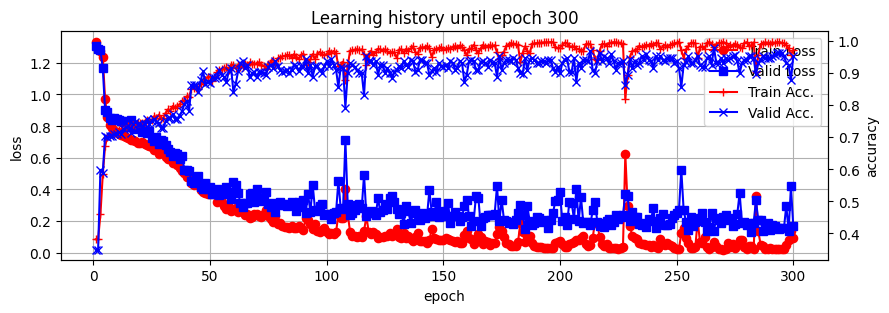

Epoch: 300, | T_Loss 0.092, | T_acc 0.971 | V_loss 0.168 | V_acc 0.951 | time  0.32
Epoch: 299, | T_Loss 0.138, | T_acc 0.956 | V_loss 0.419 | V_acc 0.877 | time  0.38
Epoch: 298, | T_Loss 0.078, | T_acc 0.975 | V_loss  0.14 | V_acc 0.924 | time  0.33
Epoch: 297, | T_Loss 0.047, | T_acc 0.986 | V_loss 0.298 | V_acc  0.93 | time  0.33
Epoch: 296, | T_Loss 0.024, | T_acc 0.992 | V_loss 0.155 | V_acc 0.951 | time  0.32
Epoch: 295, | T_Loss 0.025, | T_acc 0.993 | V_loss 0.158 | V_acc 0.961 | time  0.34
Epoch: 294, | T_Loss 0.026, | T_acc 0.996 | V_loss 0.151 | V_acc 0.961 | time  0.35
Epoch: 293, | T_Loss 0.023, | T_acc 0.995 | V_loss 0.154 | V_acc 0.961 | time  0.38
Epoch: 292, | T_Loss 0.026, | T_acc 0.993 | V_loss 0.166 | V_acc 0.956 | time  0.33
Epoch: 291, | T_Loss 0.025, | T_acc 0.994 | V_loss 0.174 | V_acc 0.951 | time  0.33
Epoch: 290, | T_Loss 0.029, | T_acc 0.991 | V_loss 0.142 | V_acc 0.946 | time  0.33
Epoch: 289, | T_Loss 0.024, | T_acc 0.993 | V_loss 0.186 | V_acc 0.946 | tim

In [16]:
maximum_epoch = 300
min_eval_loss = 99999999 # loss 갱신 여부 탐색하기 위한 변수

def epoch_not_finished():
    return epoch_cnt < maximum_epoch

# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc = epoch(train_loader, mode = 'train')
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc = epoch(val_loader, mode = 'val')
        record_valid_log(vloss, vacc)
    print_log()
    
    # vloss가 작아질 때 마다 pt 파일 갱신
    if vloss < min_eval_loss:
        min_eval_loss = vloss
        torch.save(net, '../checkpoint/action_pt/best_action40.pt')       

print('\n Training Completed')

In [38]:
# torch.save(net, "LSTM_bestyolo_length10_epoch50_flip_LSTM_batch32_.pt")

In [25]:
# net = torch.load("LSTM_bestyolo_length20_epoch130_flip_large.pt")

In [17]:
# 정확도 검증
# 체크포인트 불러오기
net = torch.load('../checkpoint/action_pt/best_action40_numlayer3.pt')
# net.load_state_dict(checkpoint['model'])
with torch.no_grad():
    test_loss, test_acc = epoch(test_loader, mode = 'test')
    test_acc = round(test_acc, 4)
    test_loss = round(test_loss, 4)
    print('Test Acc. : {}'.format(test_acc))
    print('Test Loss : {}'.format(test_loss))

Test Acc. : 0.9271
Test Loss : 0.249


In [21]:
video_path = '../data/action_data/test_data/test_data_1.MOV'
cv2.destroyAllWindows()
cap = cv2.VideoCapture(video_path)
img_list = []
length = 40
interval = 1

if cap.isOpened():
    cnt = 0
    while True:
        ret, img = cap.read()
        if ret:
            if cnt == interval:
                img_list.append(img)
                cnt = 0
            cv2.imshow("Test Video", img)
            cv2.waitKey(1)
            cnt += 1
        else:
            break
cap.release()
cv2.destroyAllWindows()
print('저장된 frame의 개수 : {}'.format(len(img_list)))

In [19]:
net.eval()
out_img_list = []
dataset = []
status = 'None'
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, model_complexity=1, enable_segmentation=False, min_detection_confidence = 0.3)
box_annotator = sv.BoxAnnotator(thickness=1, text_thickness=1, text_scale=0.5)

# 모델 정의
model = models.resnet18()
num_classes = 3  # 여기에 모델을 학습할 때 사용한 클래스 수를 지정하세요.
model.fc = nn.Linear(model.fc.in_features, num_classes)

# 저장된 가중치 로드
weights_path = "resnet18_weights_2.pt"  # 미리 저장한 가중치 파일의 경로
model.load_state_dict(torch.load(weights_path))
model.eval()

# 입력 이미지 전처리
transform = transforms.Compose([
    transforms.ToPILImage(),  # OpenCV 이미지를 PIL 이미지로 변환
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


# model = YOLO('best.pt')

# attention_dot = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                          # 25 key points
#                  14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

# draw_line = [[0, 1], [1, 2], [2, 3], [3, 7], [0, 4], [4, 5], [5, 6], [6, 8], [9, 10],   # face
#              [11, 12], [11, 23], [12, 24], [23, 24],                                    # body
#              [11, 13], [13, 15], [15, 17], [17, 19], [15, 21],                          # right arm
#              [12, 14], [14, 16], [16, 18], [18, 20], [16, 22]]                          # left arm

attention_dot = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

draw_line = [[11, 12], [11, 23], [12, 24], [23, 24],
             [11, 13], [13, 15], [15, 17], [17, 19], [15, 21],
             [12, 14], [14, 16], [16, 18], [18, 20], [16, 22]]

print("시퀀스 데이터 분석 중...")

input_list = []
for img in tqdm(img_list):
    width, height = img.shape[1], img.shape[0]
    scale_vector = np.array([width, height, width, height, 4.0])
    
    results = pose.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if not results.pose_landmarks: continue
    xy_list = []
    idx = 0
    draw_line_dic = {}
    
    # detected_idx = 0
    # yolo_result = model(img, agnostic_nms=True)[0]
    # detections = sv.Detections.from_yolov8(yolo_result)

    # labels = [f"{model.model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
    
    for x_and_y in results.pose_landmarks.landmark:
        if idx in attention_dot:
            xy_list.append(x_and_y.x)
            xy_list.append(x_and_y.y)
            x, y = int(x_and_y.x * width), int(x_and_y.y * height)
            draw_line_dic[idx] = [x, y]
        idx += 1
    
    # yolo_result = model(img, agnostic_nms=True)[0]
    # detections = sv.Detections.from_yolov8(yolo_result)
    # labels = [f"{model.model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
    
    # yolo_result = yolo_result.boxes.data.to('cpu').numpy()
    # yolo_result = yolo_result[:, [0, 1, 2, 3, 5]]
    # detection_list = yolo_result / scale_vector                                                  # Scaling the outputs of YOLO to the range (0, 1)

    # num_detection = len(detection_list)
    # if num_detection < 22:                                                                                  # if the number of detected objeects is less than the 21
    #     detection_list = np.vstack((detection_list, np.zeros((22 - num_detection, 5))))                     # pad with a zero vectors.
    
    # detection_list = detection_list.reshape(-1).tolist()                                                    # convert to list type     
    
    # xy_list += detection_list

    input_list.append(xy_list)
    
    for line in draw_line:
        x1, y1 = draw_line_dic[line[0]][0], draw_line_dic[line[0]][1]
        x2, y2 = draw_line_dic[line[1]][0], draw_line_dic[line[1]][1]
        img = cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
    # img = box_annotator.annotate(scene=img, detections=detections, labels=labels)
    
    product = ''
    if len(input_list) == length:
        dataset = []
        dataset.append({'key' : 0, 'value' : input_list})
        dataset = MyDataset(dataset)
        dataset = DataLoader(dataset)
        input_list = []
        for data, label in dataset:
            data = data.to(device)
            with torch.no_grad():
                result = net(data)
                _, act_out = torch.max(result, 1)
                
                # if obj_out.item() == 0:
                #     object_label = 'none'
                # elif obj_out.item() == 1:
                #     object_label = 'banana'
                # elif obj_out.item() == 2:
                #     object_label = 'apple'
                # else:
                #     object_label = 'orange'
                
                if act_out.item() == 0:
                    action_text = 'nothing'
                    status = action_text
                elif act_out.item() == 1:
                    action_text = 'picking_up'
                    status = action_text
                elif act_out.item() == 2:
                    action_text = 'putting_down'
                    status = action_text
                else:
                    action_text = 'holding'
                    frame_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    input_tensor = transform(frame_rgb).unsqueeze(0)
                    # 모델에 입력 전달
                    with torch.no_grad():
                        outputs = model(input_tensor)

                    # 예측 결과 확인
                    _, predicted_class = torch.max(outputs, 1)
                    if predicted_class == 0:
                        object_label = 'apple'
                    elif predicted_class == 1:
                        object_label = 'banana'
                    else:
                        object_label = 'orange'
                    
                    # print(f"Predicted class: {predicted_class.item()}")
                    status = action_text + ' ' + object_label

                    
    
    cv2.putText(img, status, (0, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
    
    out_img_list.append(img)

I0000 00:00:1702276443.305434   34542 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
W0000 00:00:1702276443.437807   34542 gl_context_egl.cc:184] Creating a context with OpenGL ES 3 failed: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:164) context_ != EGL_NO_CONTEXTCould not create GLES 3 context; eglCreateContext() returned error 0x3003
W0000 00:00:1702276443.437816   34542 gl_context_egl.cc:186] Fall back on OpenGL ES 2.
I0000 00:00:1702276443.441519   34542 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
W0000 00:00:1702276443.444774   34542 gl_context_egl.cc:184] Creating a context with OpenGL ES 3 failed: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:164) context_ != EGL_NO_CONTEXTCould not create GLES 3 context; eglCreateContext() returned error 0x3003
W0000 00:00:1702276443.444779   34542 gl_context_egl.cc:186] Fall back on OpenGL ES 2.
I0000 00:00:1702276443.450921   34542 gl_context_egl.cc:85] Su

시퀀스 데이터 분석 중...


100%|██████████| 976/976 [00:28<00:00, 33.90it/s]


In [20]:
filename = '../output_video/test_data_0_result40_wo_yolo_obj.avi'
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
fps = 30
frameSize = (width, height)
isColor = True
out = cv2.VideoWriter(filename, fourcc, fps, frameSize, isColor)
for out_img in out_img_list:
    out.write(out_img)
out.release()